# 프로젝트: 한영 번역기 만들기

## Seq2seq 기반 번역기 만들기

- 한국어를 입력으로 하여 영어로 번역된 문장을 출력하는 번역기를 만들어보자.
- __Seq2Seq__ 
    - 두 개의 RNN 모듈을 Encoder-Decoder 구조로 결합하여 사용
    - 번역기에 최적화 되어있다.
    - 한국어-영어 말뭉치 사용

- 시각화시 matplotlib 라이브러리의 기본 폰트는 한국어를 지원하지 않기 때문에, 
- Attention Map을 확인하기 위해, 한국어를 지원하는 폰트로 변경

In [1]:
import pandas
import tensorflow
import matplotlib

print(f'pandas ver. : {pandas.__version__}')
print(f'tensorflow ver. : {tensorflow.__version__}')
print(f'matplotlib ver. : {matplotlib.__version__}')

pandas ver. : 1.3.3
tensorflow ver. : 2.6.0
matplotlib ver. : 3.4.3


In [2]:
#- 나눔글꼴 설치
#! sudo apt -qq -y install fonts-nanum

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [4]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print("ok")

ok


### Data Load

- korean-english-park.train dataset에는 약 9만 4천개의 한국어-영어 pair data가 포함되어 있다.

In [5]:
cache_dir = '~/aiffel/s2s_translation'
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin = 'https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    cache_dir = cache_dir,
    extract=True
    )

In [6]:
path_to_ko = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
path_to_en = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"

In [7]:
# 한글과 영어 data 확인
with open(path_to_ko, "r") as f:
    raw_ko = f.read().splitlines()
with open(path_to_en, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size:({}, {})".format(len(raw_ko), len(raw_en)), '\n')
print("Example:")

# for sen in list(zip(raw_ko, raw_en))[0:100][::20]: print(">>", sen)

cnt = 0
for ko, en in zip(raw_ko, raw_en):
    print(f">>\n한국어 : {ko}\n영어  : {en}\n")
    cnt += 1
    if cnt == 10:
        break

Data Size:(94123, 94123) 

Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어  : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어  : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어  : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어  : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어  : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a ter

In [3]:
print('korean data size:', len(raw_kor))
print('english data size:', len(raw_en))

NameError: name 'raw_kor' is not defined

## 데이터 정제

### 중복 데이터 제거
- set 데이터형을 이용하여 중복된 데이터를 제거
    - 데이터의 병렬 쌍이 유지될 수 있도록 주의 
- pandas의 dataframe을 활용하여 중복을 제거하자. 중복을 제거한 데이터는 cleaned_corpus에 저장


- set을 이용하여 중복 제거 (pair 유지) < 훨씬 간단
- dataframe의 drop_duplicated 활용 < 시각화 용이

In [8]:
# set을 이용하여 중복 제거 (pair 유지)
cleaned_corpus = list(set(zip(raw_ko, raw_en)))
len(cleaned_corpus)

78968

In [9]:
cleaned_corpus[0:100:20]

[('perk 임직원의 특혜(특전) advisor 보좌관, 고문',
  '“His representatives say that those advisors can just turn around and give the information to him.”'),
 ("“'다크나이트'와 함께 우리 곁을 떠난 배우가 골드글로브상 후보로 지명되었습니다.”",
  '“The late actor who ran away with the Dark Knight picked up a Golden Globe Nomination…”'),
 ('파키스탄과 아프간은 미국이 주도하고 있는 테러와의 전쟁에서 중요한 동맹국이다.',
  '¡°It exactly gives us the right to go back and do the same. ¡°'),
 ('늘어난 수많은 왕실 가족들과 여러 사회 인사들을 초대한 가운데 찰스 왕세자가가 후원하는 필하모닉 오케스트라가 공연이 있었다.',
  'The Philharmonic Orchestra, of which the prince is patron, was to play for invited members of the extended royal family and assorted society figures.'),
 ('프리미어리그 선두인 아스널과 2006 챔피언스리그 우승팀인 리버풀은 첼시와 터키의 페네르바체 승자와 4강에서 격돌한다.',
  'Premier League leaders Arsenal or 2006 Champions League winners Liverpool could face another English team in the semifinals if Chelsea overcome Turkish opponents Fenerbahce.')]

In [10]:
# dataframe의 drop_duplicated 활용
import pandas as pd

pair_df = pd.DataFrame({'Korean':raw_ko, 'English':raw_en})
pair_df

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [11]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Korean   94123 non-null  object
 1   English  94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [12]:
# object type 요약통계 확인
pair_df.describe(include='object').transpose()

,count,unique,top,freq
Korean,94123,77591,[동영상]추신수 스리런 홈런 작렬!,554
English,94123,75598,Lee will explain his shift on S...,554


<AxesSubplot:>

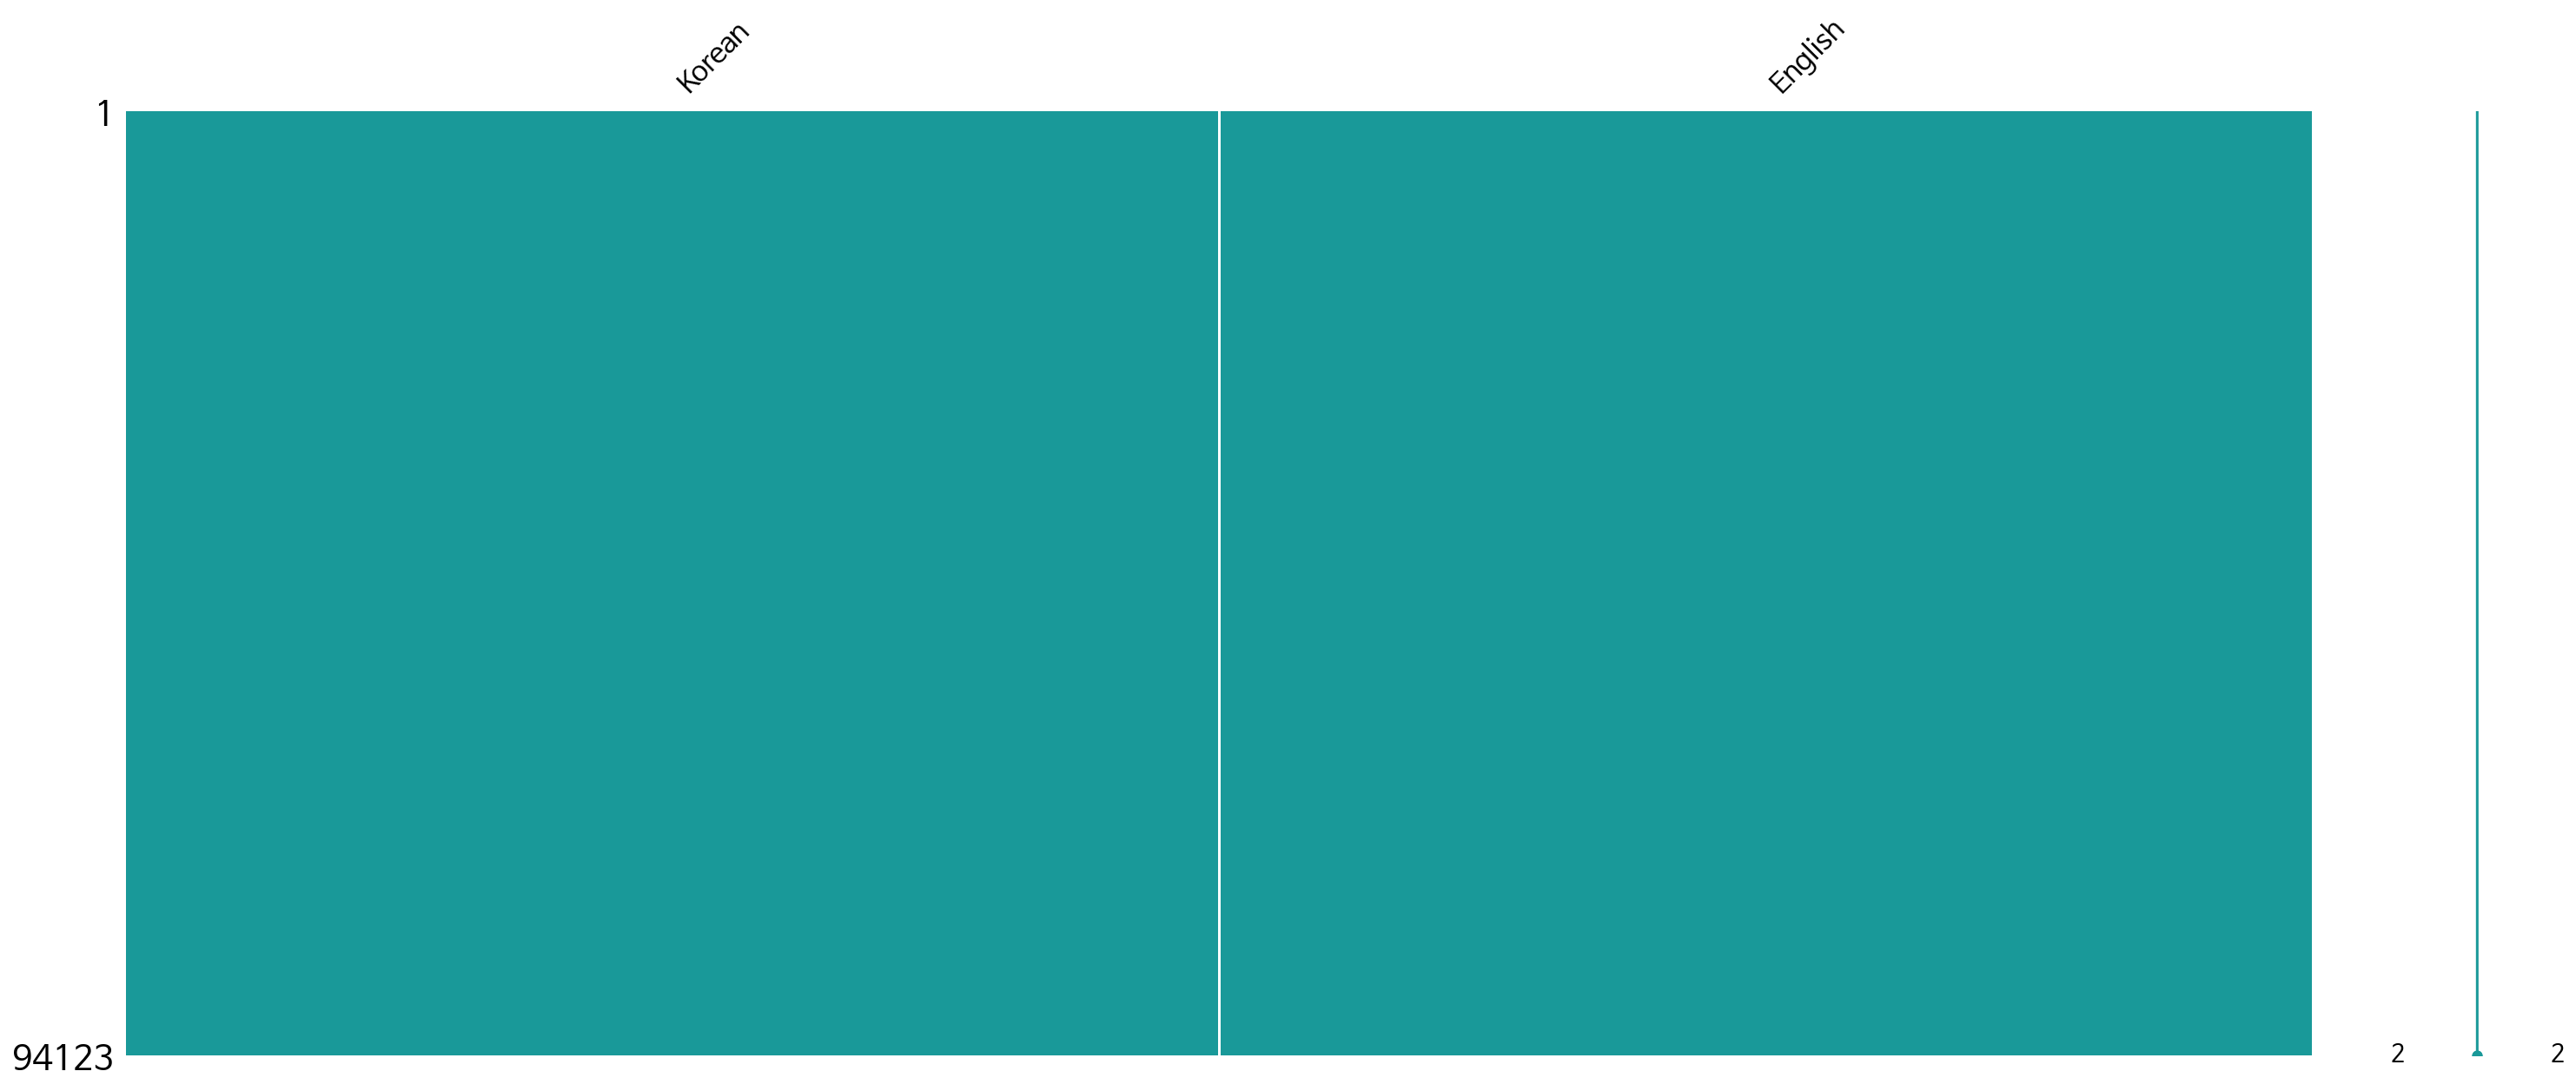

In [13]:
import missingno as msno  

# 결측값 확인(matrix)
msno.matrix(pair_df, color=(0.1, 0.6, 0.6))   # color = (R, G, B)

<AxesSubplot:>

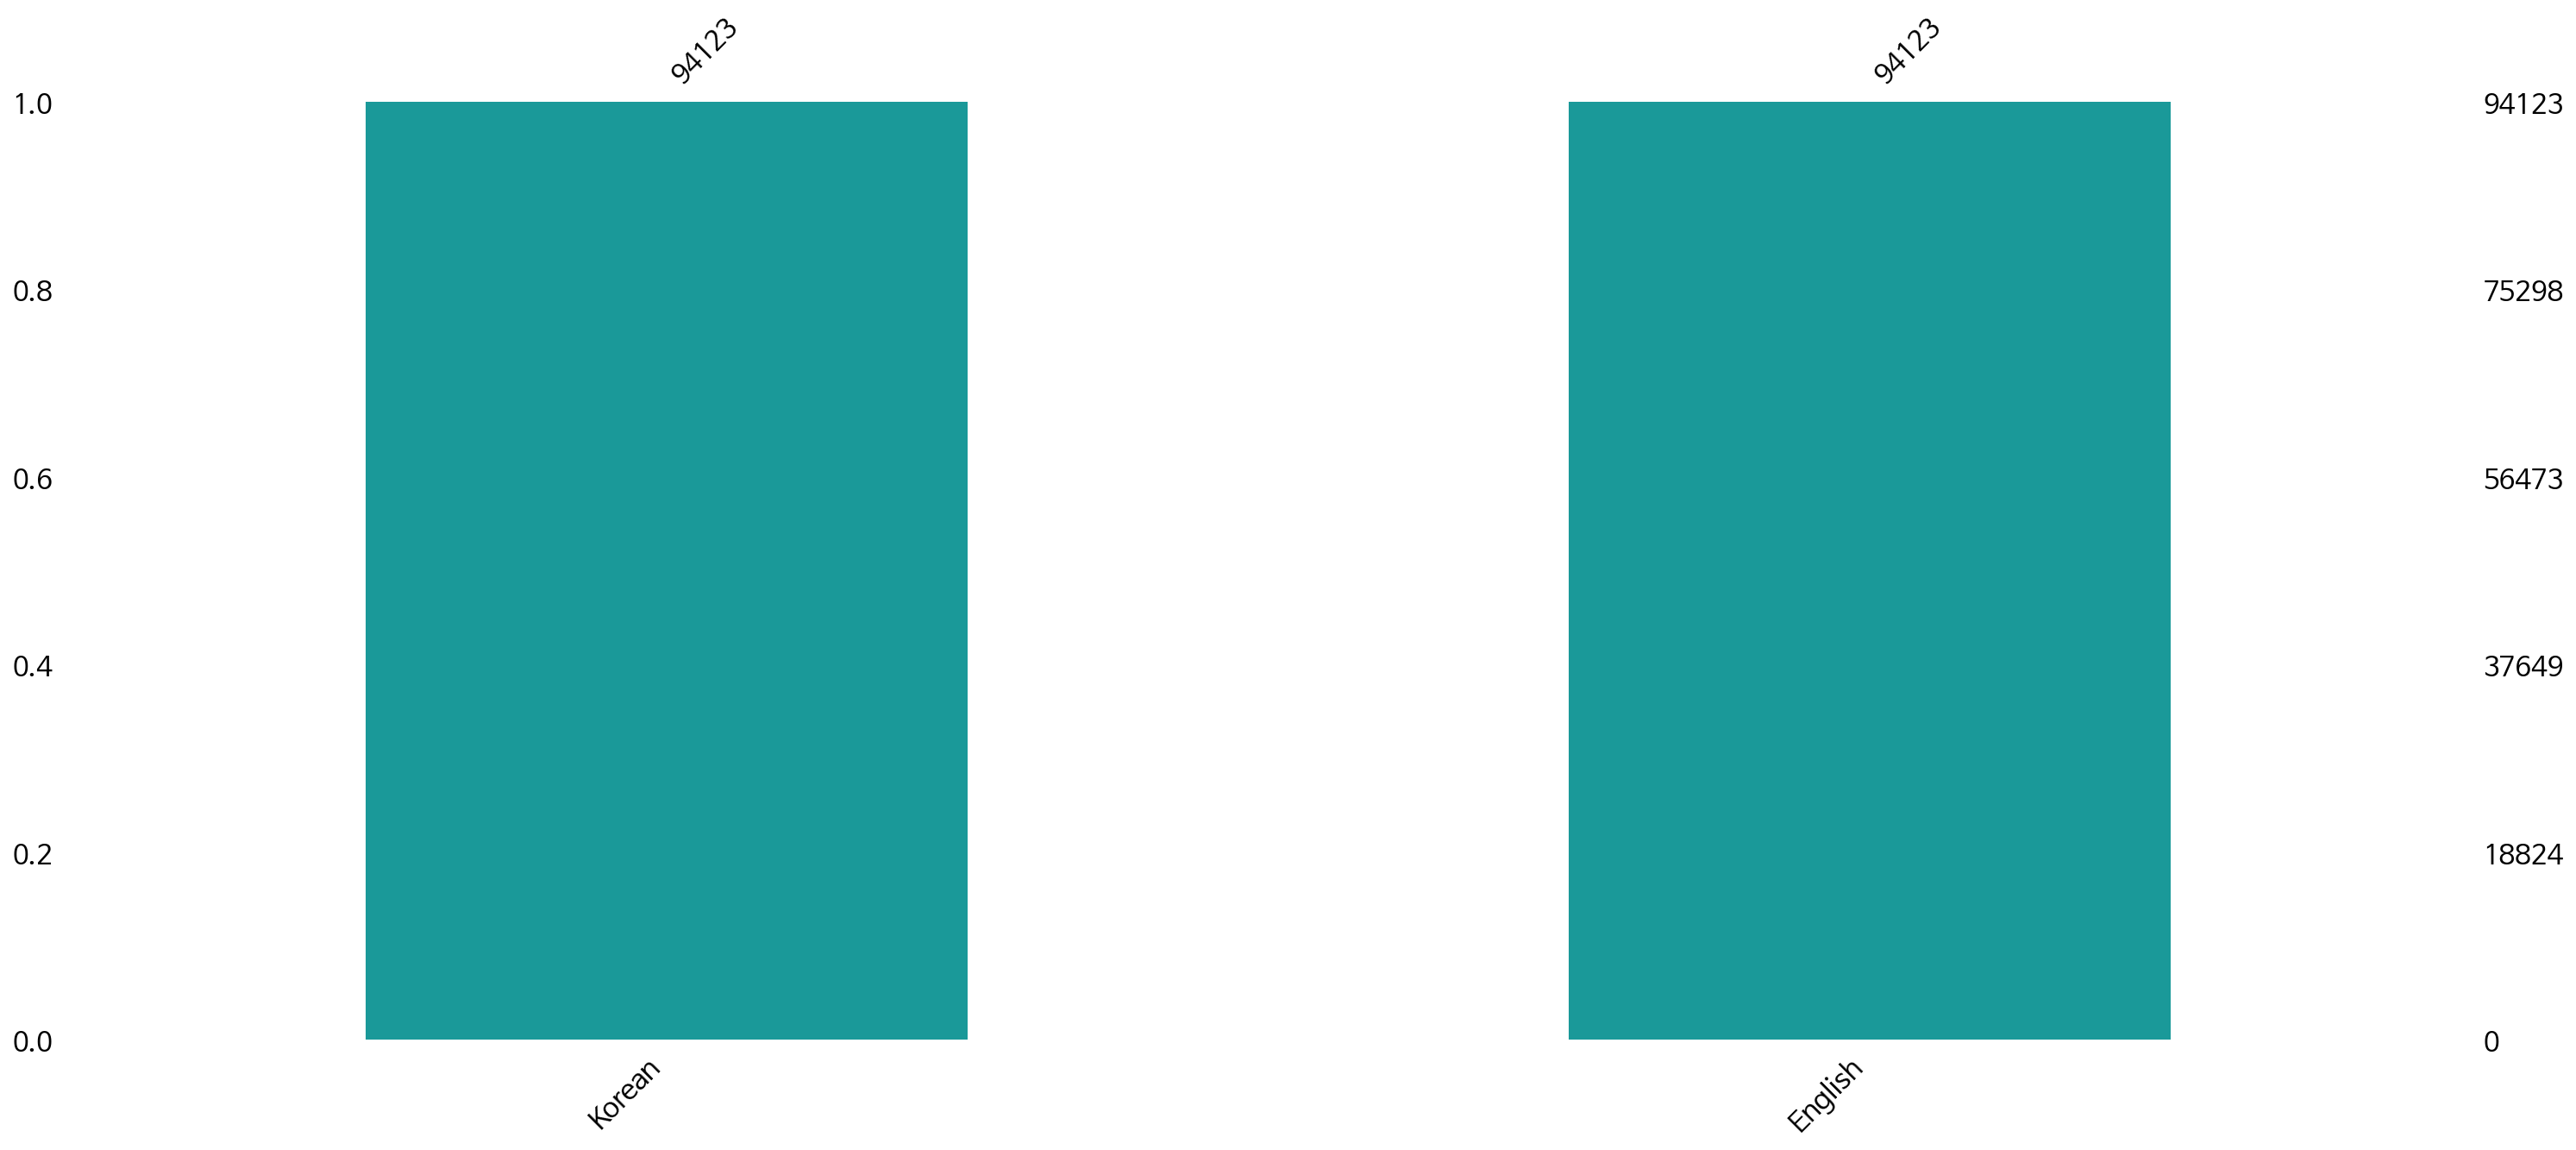

In [14]:
# 결측값 확인(bar chart)
msno.bar(pair_df, color=(0.1, 0.6, 0.6))

In [15]:
# 각 column 별 unique 수
pair_df.nunique()

Korean     77591
English    75598
dtype: int64

In [16]:
# 결측치 수량 검출
pair_df.isna().sum().sort_values(ascending=False)

Korean     0
English    0
dtype: int64

In [17]:
# 중복 데이터 확인
pair_df[pair_df.duplicated()]

,Korean,English
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
9925,*판매 제품,The goods
10070,* 알아두면 좋은 것:,Good to know:
10074,* 알아두면 좋은 것:,Good to know:
10079,* 알아두면 좋은 것:,Good to know:
...,...,...
93792,"힐러리 클린턴, 북한 방문할까",Would Hillary Clinton visit North Korea?
93793,"이라크 새 의회, 첫 개정",Iraq’s new assembly is going to hold its first...
93933,"노 대통령 검찰, 민주적 통제 받아야 2005.12",Roh says prosecutors need civilian control.
94002,"카우치 멤버, 사전 모의 시인 2005.09",Members of The Couch planned it before the show.


- 약 1만5천개의 중복 데이터가 있음을 확인

In [18]:
pair_df.nunique()

Korean     77591
English    75598
dtype: int64

In [19]:
pair_df.drop_duplicates(inplace=True)
print(pair_df.shape)
pair_df[pair_df.duplicated()]

(78968, 2)


,Korean,English


### preprocessing

- 한글에 적용할 수 있는 정규식 추가
- 타겟 언어인 영문에는 `<start>` 토큰과 `<end>` 토큰 추가 및 split() 함수 이용하여 토큰화

In [1]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    
    # 단어와 구두점(punctuation)사이의 거리 생성
    sentence = re.sub(r"([?.!,])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)  # 여러개의 공백은 하나의 공백으로 바꾸기
    # (ㄱ-ㅎ, ㅏ-ㅣ 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()  # 양쪽 공백 제거
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [2]:
for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    print(kor, eng)
    break

NameError: name 'cleaned_corpus_kor' is not defined

In [21]:
enc_corpus = []
dec_corpus = []

for pair in cleaned_corpus:
    ko, en = pair[0], pair[1]
    enc_corpus.append(preprocess_sentence(ko))
    dec_corpus.append(preprocess_sentence(en, s_token=True, e_token=True))

print("Korean :", enc_corpus[777])
print("English:", dec_corpus[777])

Korean : 그래슬리 의원은 모든 부담을 중산층이 져야 한다고 말하며 경기부양책과 오바마의 조 천억 원 규모 예산안에 극히 비판적인 태도를 취하고 있습니다 .
English: <start> Grassley is sharply critical of the economic stimulus plan and Obama s proposed . trillion budget , saying the price tag will have to be covered by the middle class . <end>


In [22]:
for idx, val in enumerate(enc_corpus):
    print(f'idx : {idx}, val : {val}')
    if idx == 500:
        break

idx : 0, val : perk 임직원의 특혜 특전 advisor 보좌관 , 고문
idx : 1, val : 지금 까지 발견된 초대형 오징어 중 가장 큰 것은 뉴질랜드 어부가 풀어놓은 망에 잡힌 것으로 무게가 약 kg , 길이는 약 m에 이른다 .
idx : 2, val : 이에앞서 시드로에서도 무장세력의 로켓포 공격으로 명이 부상했으며 그중 명은 치료를 받던 중 사망했다고 의료진이 전했다 .
idx : 3, val : 감염된 성장 호르몬 주사를 맞은 수천 명의 사람들이 CJD병에 걸리지 않았다 .
idx : 4, val : 구글은 이번주 초 샌프란시스코만 지역 , 뉴욕 , 라스베이거스 , 덴버 , 마이애미의 구글지도를 스트리트 뷰 에 소개 , 놀라움을 이끌어낼 것을 기대하고있다 .
idx : 5, val : 오바마 대통령은 그의 주간 라디오 및 인터넷 연설에서 하원을 통과한 , 억 달러 이상 규모의 경기부양책에 대해 상원이 빠르게 움직여 줄 것을 요구했습니다 .
idx : 6, val : 불가리아와 EU는 간호사들이 혐의가 없으며 벤가지 병원에서 긴 기간 동안 환자들을 위해 봉사해 왔다고 지적했다 .
idx : 7, val : 년 개교하는 이 학교는 명의 신입생과 최대 명의 외국 학생을 모집할 예정이다 .
idx : 8, val : 숙박비 카드 결재
idx : 9, val : 니콜라 사르코지 프랑스 대통령이 직접 콜롬비아 반군단체에게 지난 년간 콜롬비아 반군에 억류중인 프랑스 인질의 석방을 호소했다 .
idx : 10, val : 이 작업은 다양한 스타일의 인간 생체를 이용한 컴퓨터 접속 장치에 대한 NTT DoCoMo 연구팀의 연구 조사의 일환이었다 .
idx : 11, val : 세계 오케스트라 , 평화를 위해 연주하다
idx : 12, val : 크리스토퍼 힐 미 자 회담 수석대표는 금강산 관광사업이 북한 권부의 돈줄 역할을 한다며 대북 관광사업에 대한 미국 정부의 반대 입장을 표명했다 .
idx : 13, val : 시위대는 중국이 아웅산수치의 석

- 위 데이터셋 자체의 신뢰도가 낮은 것을 확인할 수 있다.
- 해석이 다른 문장과 서로 짝이 구성된 문장도 있고 한글 원문에 영어와 한글 번역이 같이 있는 것도 있다.

In [23]:
for idx, val in enumerate(dec_corpus):
    print(f'idx : {idx}, val : {val}')
    if idx == 500:
        break

idx : 0, val : <start> His representatives say that those advisors can just turn around and give the information to him . <end>
idx : 1, val : <start> It is widely believed to be the largest specimen of the rare and mysterious deep water species Mesonychoteuthis hamiltoni , or colossal squid , ever caught . <end>
idx : 2, val : <start> Early Sunday a Qassam rocket hit Sderot , wounding two people one who later died from the injuries , Israeli medical services said . Watch workers pull rocket remains from pavement <end>
idx : 3, val : <start> Thousands of patients who received infected growth hormone did not get CJD <end>
idx : 4, val : <start> Google is hoping to elicit oohs and ahhs with Street View , which was introduced on its maps for the San Francisco Bay area , New York , Las Vegas , Denver and Miami earlier this week . <end>
idx : 5, val : <start> In his weekly radio and Internet speech , Obama called on the Senate to act quickly on the House passed billion stimulus bill . <end>

### 데이터 토큰화

- tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각 tokenizer를 얻는다.
- 단어의 수는 20,000 개
- 한글 토큰화는 KoNLPy의 mecab 클래스 사용
- cleaned_corpus 로부터 토큰의 길이가 30이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축
- keras Tokenizer.index에서 num_words인자 설정에 따라 이후 사용되는 vocab의 사이즈가 결정
- 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않겠습니다.


In [24]:
from konlpy.tag import Mecab
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
def tokenize(corpus, vocab_size = 20000, maxlen=30, mecab=False):
    
    if mecab:
        mecab = Mecab()
        x_train = []
        for sen in corpus:
            x = mecab.morphs(sen)
            x_train.append(x)
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(vocab_size)
        vocab = ['','']+[key for key,_ in counter]
        word_to_index = {word : index for index, word in enumerate(vocab)} #- word : index 사전
        
        word_to_index["<PAD>"] = 0
        word_to_index["<UNK>"] = 1
        
        def wordlist_to_indexlist(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
        
        x_train = list(map(wordlist_to_indexlist, x_train))
        

        index_to_word = {index:word for word, index in word_to_index.items()}

        x_train = pad_sequences(x_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)
        
        return x_train, word_to_index

    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
        tokenizer.fit_on_texts(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=maxlen, padding='post')
        return tensor, tokenizer

In [26]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus, vocab_size = 20000-3, maxlen=30, mecab=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, vocab_size = 20000+1, maxlen=30, mecab=False)

In [27]:
print("Korean Vocab Size:", len(enc_tokenizer))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 20000
English Vocab Size: 44689


### 모델 설계

- Attention 기반 Seq2seq 모델 설계
- dropout 모듈을 추가하여 성능향상 시도
- Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰주자

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        # score shape == (batch_size, max_length, 1)
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # attention weights shape == (batch_size, max_length, 1)
        attn = tf.nn.softmax(score, axis=1)
        
        # context vector shape after sum == (batch_size, hidden_size)
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       dropout=0.3,
                                       return_sequences=True)
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       dropout=0.3,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
    
    
    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [30]:
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

### 훈련

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [32]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm


Epoch 10: 100%|██████████| 2468/2468 [05:52<00:00,  7.00it/s, Loss 5.2854]


### 평가

- 아래 예문에 대한 번역을 생성해봅니다.
- Attention Map을 시각화합니다.

### 예문 ###

- K1) 오바마는 대통령이다.

`>> obama is the president .`

- K2) 시민들은 도시 속에 산다.

`>>  citizens are bracing for the city .`

- K3) 커피는 필요 없다.

`>> there is no change .`

- K4) 일곱 명의 사망자가 발생했다.

`>> the death toll was dead .`

In [33]:
def evaluate(sentence, encoder, decoder):
    mecab = Mecab()
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = mecab.morphs(sentence)
    inputs = [[enc_tokenizer[word] if word in enc_tokenizer else enc_tokenizer["<UNK>"] for word in sentence]]
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                        value=enc_tokenizer["<PAD>"],
                        padding='post',
                        maxlen=enc_tensor.shape[-1])
    print(inputs)

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

[[110, 5, 47, 4, 3, 2]]
[[110   5  47   4   3   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_48/2263444133.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2263444133.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


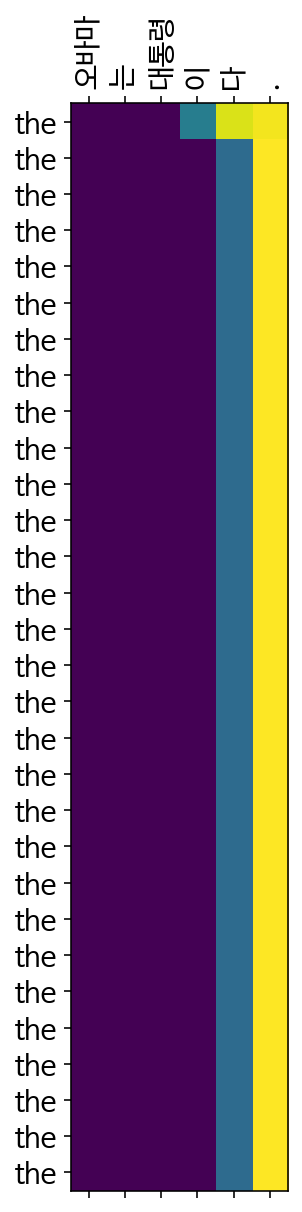

[[514, 15, 9, 322, 577, 8, 1, 2]]
[[514  15   9 322 577   8   1   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


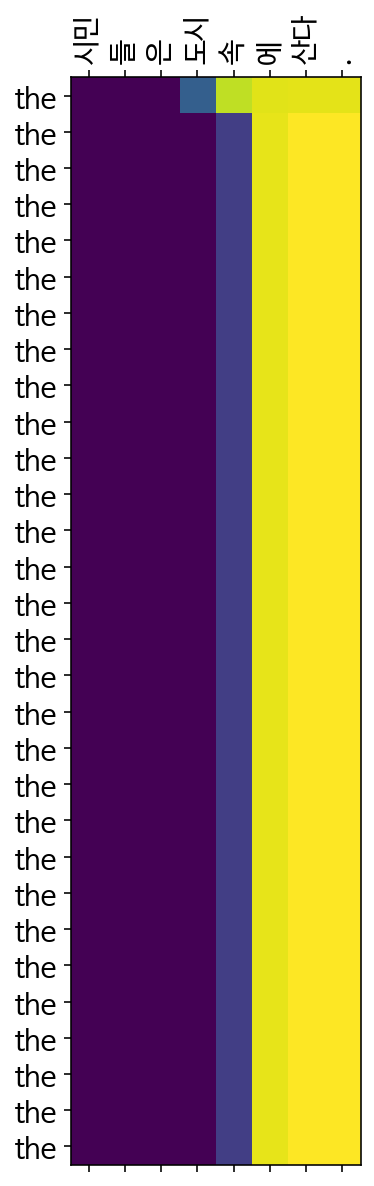

[[2677, 5, 222, 69, 3, 2]]
[[2677    5  222   69    3    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


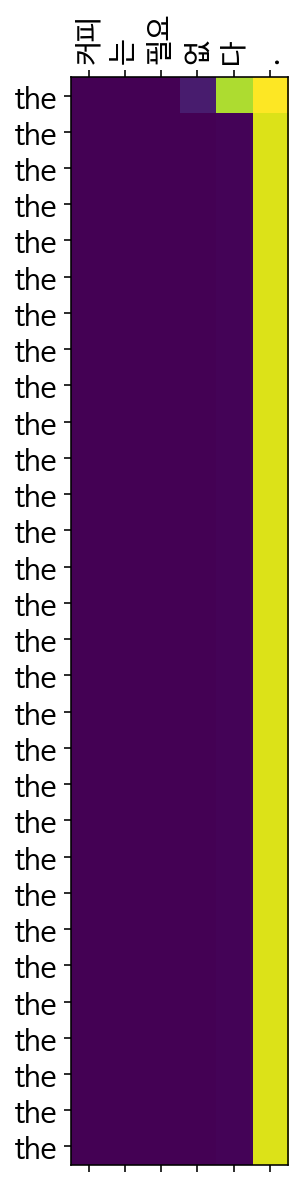

[[6140, 33, 7, 516, 16, 89, 12, 3, 2]]
[[6140   33    7  516   16   89   12    3    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


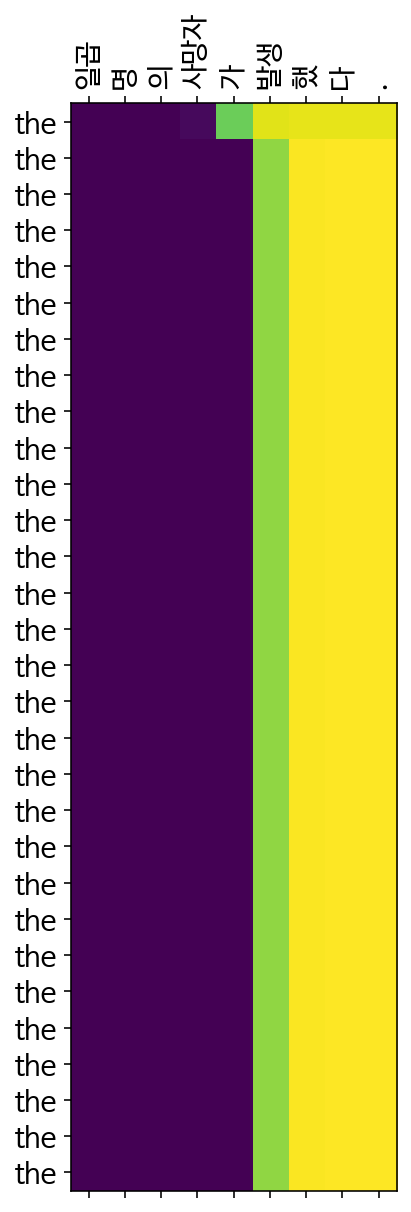

In [34]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

[[1691, 18, 39, 5868, 3, 2]]
[[1691   18   39 5868    3    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input: ['불과', ',', '년', '전이', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_48/2263444133.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2263444133.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


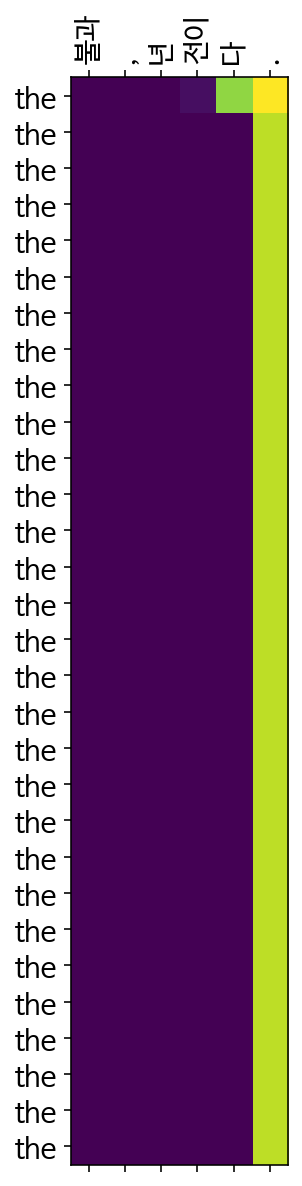

In [35]:
translate("불과 1,379년 전이다.", encoder, decoder)

[[305, 5, 514, 7, 1129, 4, 3]]
[[ 305    5  514    7 1129    4    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input: ['투표', '는', '시민', '의', '권리', '이', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_48/2263444133.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2263444133.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


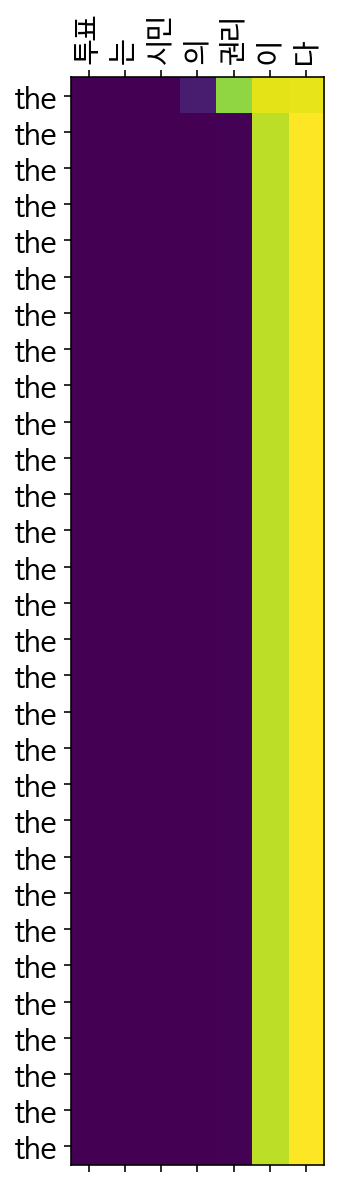

In [36]:
translate("투표는 시민의 권리이다", encoder, decoder)

[[4069, 154, 578, 16, 19, 343, 8, 208, 13, 14, 65, 2]]
[[4069  154  578   16   19  343    8  208   13   14   65    2    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input: ['곰', '세', '마리', '가', '한', '집', '에', '살', '고', '있', '습니다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_48/2263444133.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2263444133.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


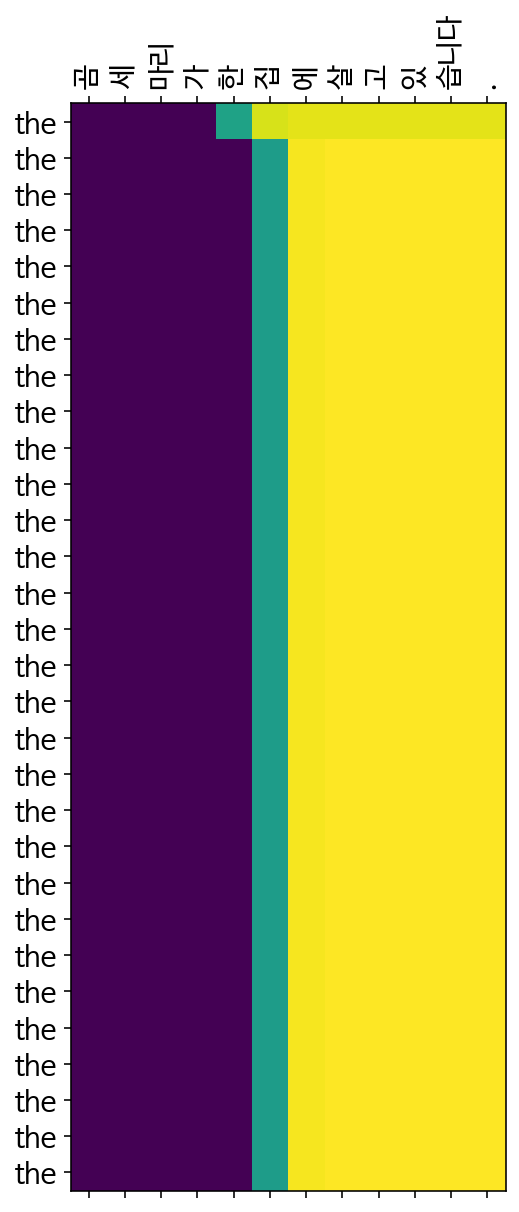

In [37]:
translate("곰 세마리가 한집에 살고 있습니다.", encoder, decoder)

[[478, 66, 5, 10545, 10747, 18, 1, 18, 1, 7, 265, 31, 24, 702, 4, 3, 2]]
[[  478    66     5 10545 10747    18     1    18     1     7   265    31
     24   702     4     3     2     0     0     0     0     0     0     0
      0     0     0     0     0     0]]
Input: ['음', '주', '는', '만성', '간염', ',', '간경변증', ',', '간암', '의', '대표', '적', '인', '원인', '이', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_48/2263444133.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2263444133.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


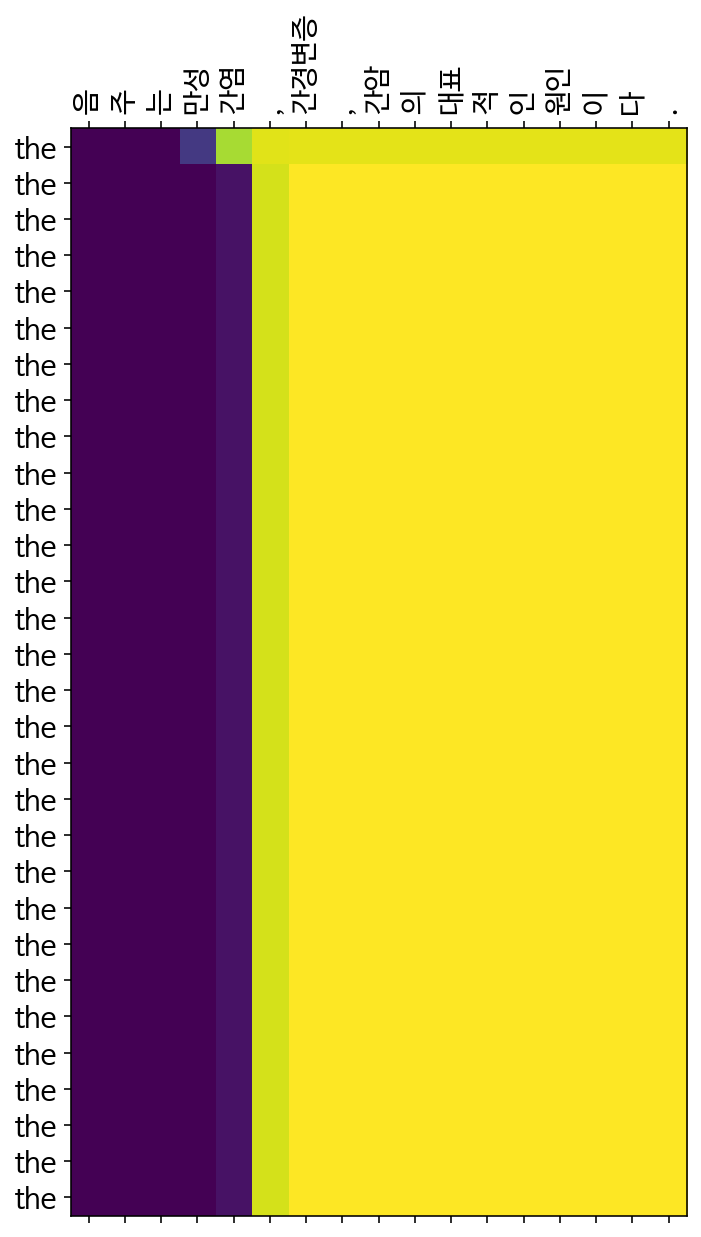

In [38]:
translate("음주는 만성간염, 간경변증, 간암의 대표적인 원인이다. ", encoder, decoder)

[[2677, 327, 7, 222, 100, 6, 969, 5, 5584, 5184, 9, 308, 25, 92, 3]]
[[2677  327    7  222  100    6  969    5 5584 5184    9  308   25   92
     3    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input: ['커피', '중단', '의', '필요', '성', '을', '알리', '는', '카페인', '부작용', '은', '다음', '과', '같', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_48/2263444133.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2263444133.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


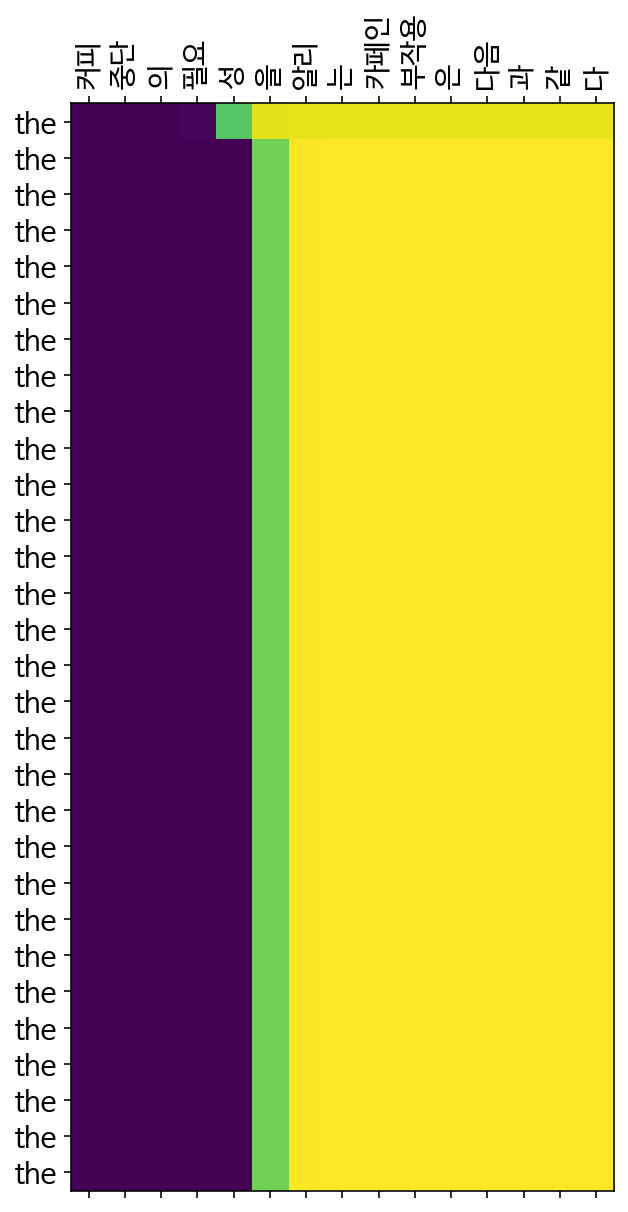

In [39]:
translate("커피중단의 필요성을 알리는 카페인 부작용은 다음과 같다", encoder, decoder)

- 번역이 제대로 된 문장이 하나도 없었다. 왜? 그럴까? 
- 이는 앞에서도 지적했듯이 데이터셋의 쌍이 잘못 구성된 부분에 기인한 것으로 생각된다.
- 숫자(일곱 명, 5배, 17시간)는 번역하지 못합니다. 전처리 과정에서 숫자까지 제거되어 학습이 제대로 되지 않은 듯 합니다.
- 번역기의 성능을 높이기 위해서는 데이터셋 쌍이 맞지 않거나 번역이 잘못되어 있는 부분을 제대로 수정 및 정제해야 할 것으로 보인다.